# Задача 5. Обучение без учителя

* **Дедлайн**: 14.03.2025, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.
- Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- Самостоятельно реализуйте один из алгоритмов кластеризации, например **K-means**.
- Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из **sklearn** (**KMeans**, **Affinity Propogation**, **DBSCAN** и тд).
- При обучении использовать **подбор гиперпараметров**.
- Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.
- * (**+3 балла**) Также снизить размерность данных с помощью метода главных компонент **PCA** и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
- * (**+2 балла**) Визуализировать данные снижением размерности до 2 или 3 с помощью **PCA** и **t-SNE**. В случае проблем с производительностью **t-SNE**, можно сначала до какой то степени снизить размерность с помощью **PCA**, а затем запустить **t-SNE**.

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.preprocessing import StandardScaler, LabelEncoder
from ucimlrepo import fetch_ucirepo
from sklearn.cluster import KMeans, AffinityPropagation, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import time


# EDA
[Dataset](https://archive.ics.uci.edu/dataset/942/rt-iot2022)

In [2]:
rt_iot2022 = fetch_ucirepo(id=942)

X = rt_iot2022.data.features
y = rt_iot2022.data.targets


Краткий обзор данных

In [3]:
print(X.head())
print(X.info())

   id.orig_p  id.resp_p proto service  flow_duration  fwd_pkts_tot  \
0      38667       1883   tcp    mqtt      32.011598             9   
1      51143       1883   tcp    mqtt      31.883584             9   
2      44761       1883   tcp    mqtt      32.124053             9   
3      60893       1883   tcp    mqtt      31.961063             9   
4      51087       1883   tcp    mqtt      31.902362             9   

   bwd_pkts_tot  fwd_data_pkts_tot  bwd_data_pkts_tot  fwd_pkts_per_sec  ...  \
0             5                  3                  3          0.281148  ...   
1             5                  3                  3          0.282277  ...   
2             5                  3                  3          0.280164  ...   
3             5                  3                  3          0.281593  ...   
4             5                  3                  3          0.282111  ...   

    active.avg  active.std     idle.min     idle.max     idle.tot  \
0  2282414.913         0.0  2

Проверка пропусков


In [4]:
print(X.isnull().sum().sum())

0


Базовая статистика признаков

In [5]:
print(X.describe())

           id.orig_p      id.resp_p  flow_duration   fwd_pkts_tot  \
count  123117.000000  123117.000000  123117.000000  123117.000000   
mean    34639.258738    1014.305092       3.809566       2.268826   
std     19070.620354    5256.371994     130.005408      22.336565   
min         0.000000       0.000000       0.000000       0.000000   
25%     17702.000000      21.000000       0.000001       1.000000   
50%     37221.000000      21.000000       0.000004       1.000000   
75%     50971.000000      21.000000       0.000005       1.000000   
max     65535.000000   65389.000000   21728.335580    4345.000000   

        bwd_pkts_tot  fwd_data_pkts_tot  bwd_data_pkts_tot  fwd_pkts_per_sec  \
count  123117.000000      123117.000000      123117.000000      1.231170e+05   
mean        1.909509           1.471218           0.820260      3.518063e+05   
std        33.018311          19.635196          32.293948      3.707645e+05   
min         0.000000           0.000000           0.000000

In [6]:
print(X.dtypes[X.dtypes == 'object'])


proto      object
service    object
dtype: object


In [7]:
X_encoded = pd.get_dummies(X, columns=['proto', 'service'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

## Метод локтя

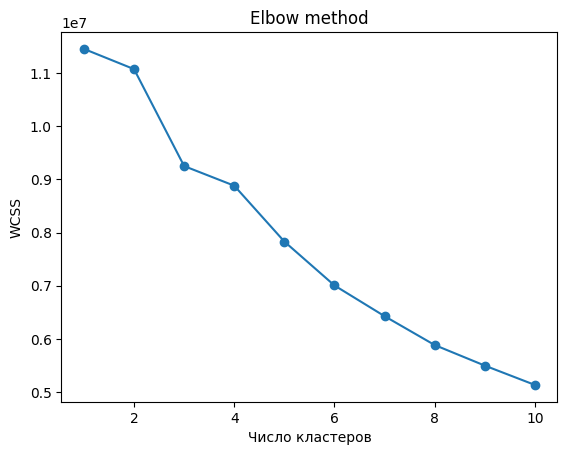

In [16]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Число кластеров')
plt.ylabel('WCSS')
plt.title('Elbow method')
plt.show()

## Коэффициент силуэта

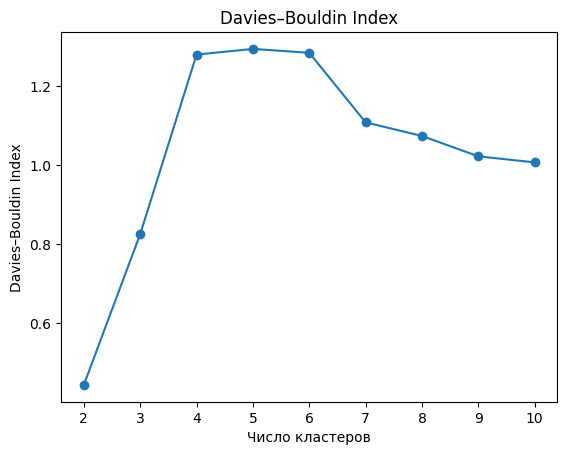

In [17]:
db_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = davies_bouldin_score(X_scaled, labels)
    db_scores.append(score)

plt.plot(range(2, 11), db_scores, marker='o')
plt.xlabel('Число кластеров')
plt.ylabel('Davies–Bouldin Index')
plt.title('Davies–Bouldin Index')
plt.show()

Сочетание метода локтя и анализа индекса Дэвиса–Болдина показывает, что при 4 кластерах мы получаем разумный баланс между «компактностью» внутри кластеров и умеренным значением индекса DB. Кроме того, именно в районе 4–5 кластеров наблюдается явный «излом» по WCSS, поэтому 4 кластера выглядят оптимальным выбором.

## PCA

In [8]:
def plot_2d(result, title, labels):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(result[:, 0], result[:, 1], c=labels, cmap='viridis', s=10)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

def plot_3d(result, title, labels):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(result[:, 0], result[:, 1], result[:, 2], c=labels, cmap='viridis', s=10)
    plt.colorbar(scatter)
    ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.show()
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y.values.flatten())

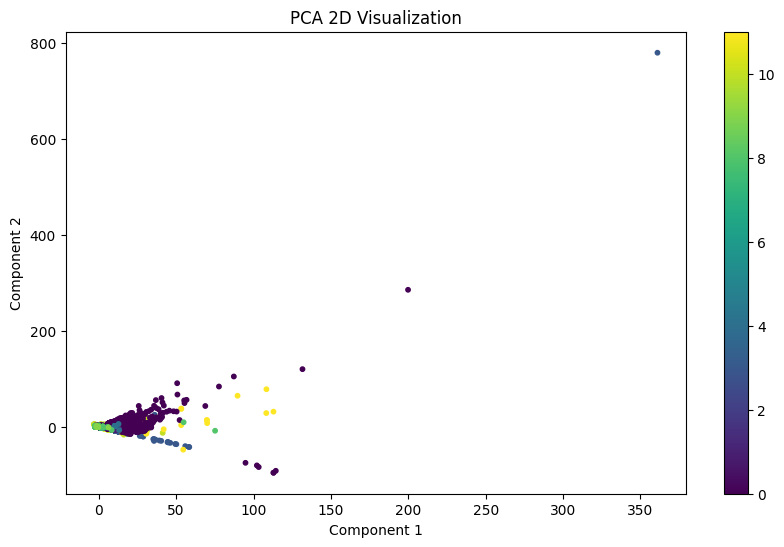

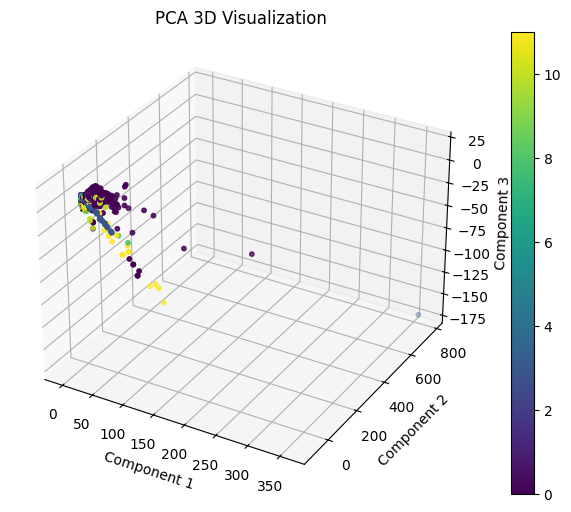

In [9]:
pca_2d = PCA(n_components=2)
pca_result_2d = pca_2d.fit_transform(X_scaled)

pca_3d = PCA(n_components=3)
pca_result_3d = pca_3d.fit_transform(X_scaled)

plot_2d(pca_result_2d, "PCA 2D Visualization", y_encoded)
plot_3d(pca_result_3d, "PCA 3D Visualization", y_encoded)

## t-SNE

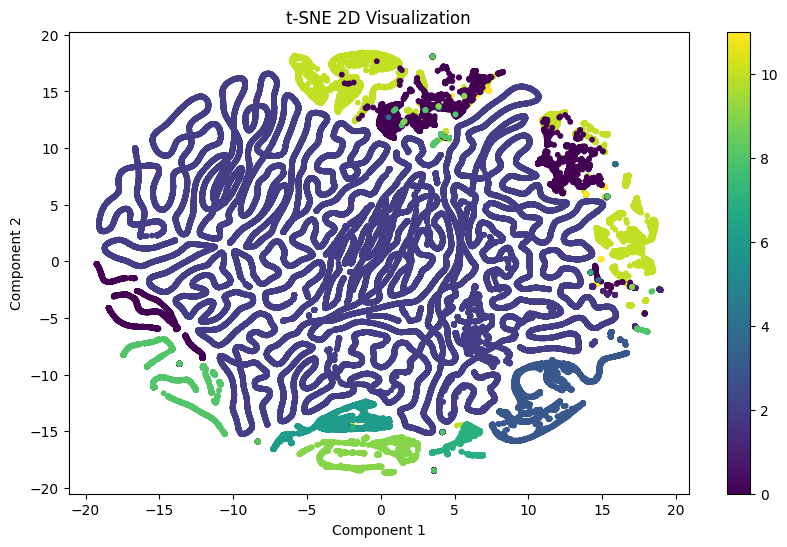

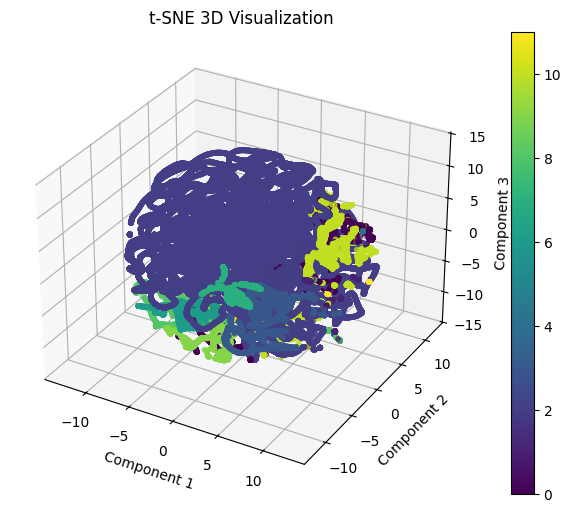

In [10]:
tsne_2d = TSNE(n_components=2, perplexity=30, max_iter=300, random_state=42)
tsne_result_2d = tsne_2d.fit_transform(X_scaled)

tsne_3d = TSNE(n_components=3, perplexity=30, max_iter=300, random_state=42)
tsne_result_3d = tsne_3d.fit_transform(X_scaled)

plot_2d(tsne_result_2d, "t-SNE 2D Visualization", y_encoded)
plot_3d(tsne_result_3d, "t-SNE 3D Visualization", y_encoded)


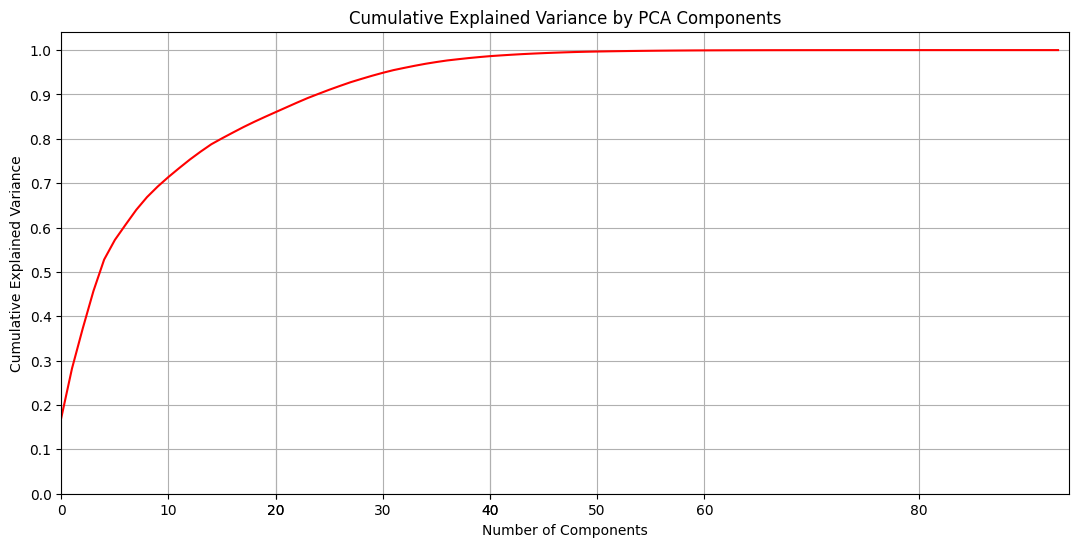

In [11]:
pca_full = PCA().fit(X_scaled)

plt.figure(figsize=(13, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), color='red')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(list(plt.xticks()[0]) + [10, 20, 30, 40, 50])
plt.xlim(0, len(pca_full.explained_variance_ratio_))
plt.grid(True)
plt.title("Cumulative Explained Variance by PCA Components")
plt.show()

По графику видно, что уже к 30–40 компонентам суммарная объяснённая дисперсия приближается к 90–95%, после чего рост кривой замедляется и достигает почти 100% к 60–70 компонентам. Это говорит о том, что первые 30–40 главных компонент «объясняют» большую часть вариации в данных, и дальнейшее увеличение числа компонент даёт лишь небольшой прирост объяснённой дисперсии.

## Самостоятельная реализация алгоритма кластеризации K-means


In [9]:
class CustomKMeans:
    def __init__(self, n_clusters=4, max_iter=300, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.centroids = None

    def fit_predict(self, X):
        np.random.seed(self.random_state)
        self.centroids = X[np.random.choice(range(X.shape[0]), self.n_clusters, replace=False)]
        for _ in range(self.max_iter):
            labels = np.argmin(np.linalg.norm(X[:, None] - self.centroids, axis=2), axis=1)
            new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(self.n_clusters)])
            if np.allclose(new_centroids, self.centroids):
                break
            self.centroids = new_centroids
        return labels


In [10]:
def cluster_tuning(X, model_class, param_grid):
    best_score = -1
    best_params = None
    best_labels = None

    for params in ParameterGrid(param_grid):
        model = model_class(**params)
        labels = model.fit_predict(X)

        unique_labels = set(labels)
        if len(unique_labels) <= 1 or len(unique_labels) >= len(X):
            continue

        score = silhouette_score(X, labels)

        if score > best_score:
            best_score = score
            best_params = params
            best_labels = labels

    return best_params, best_score, best_labels

### Подбор параметров


In [15]:
custom_kmeans_params = {
    'n_clusters': [4],
    'max_iter': [100, 200, 300, 500]
}

best_params_Customkmeans, best_score_Customkmeans, labels_Customkmeans = cluster_tuning(
    X_scaled, CustomKMeans,
    custom_kmeans_params
)
print('CustomKMeans:', best_params_Customkmeans, best_score_Customkmeans)

CustomKMeans: {'max_iter': 200, 'n_clusters': 4} 0.3933277699381629


In [16]:
KMeans_param = {'n_clusters': [4], 'init': ['k-means++', 'random'], 'n_init': [10, 20, 30]}
best_params_kmeans, best_score_kmeans, labels_kmeans = cluster_tuning(
    X_scaled, KMeans,
    KMeans_param
)
print('KMeans:', best_params_kmeans, best_score_kmeans)

KMeans: {'init': 'random', 'n_clusters': 4, 'n_init': 10} 0.5533963756257014


In [14]:
affinity_params = {
    'damping': [0.5, 0.7, 0.9],
    'preference': [-50, -100],
    'max_iter': [1000]
}

from sklearn.utils import shuffle

X_sampled = shuffle(X_scaled, random_state=42)[:5000]

best_params, best_score, labels = cluster_tuning(
    X_sampled, AffinityPropagation, affinity_params
)

print('AffinityPropagation (на подвыборке):', best_params, best_score)

C:\Users\temer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
C:\Users\temer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
C:\Users\temer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
C:\Users\temer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and l

AffinityPropagation (на подвыборке): {'damping': 0.9, 'max_iter': 1000, 'preference': -50} 0.5663761048618727


In [20]:
def cluster_tuning_with_timing(X, model_class, param_grid):
    best_score = -1
    best_labels = None
    best_time = None

    for params in ParameterGrid(param_grid):
        model = model_class(**params)
        start_time = time.time()
        labels = model.fit_predict(X)
        elapsed_time = time.time() - start_time

        unique_labels = set(labels)
        if len(unique_labels) <= 1 or len(unique_labels) >= len(X):
            continue

        score = silhouette_score(X, labels)

        if score > best_score:
            best_score = score
            best_labels = labels
            best_time = elapsed_time

    return best_score, best_labels, best_time

### Сравенение моделей


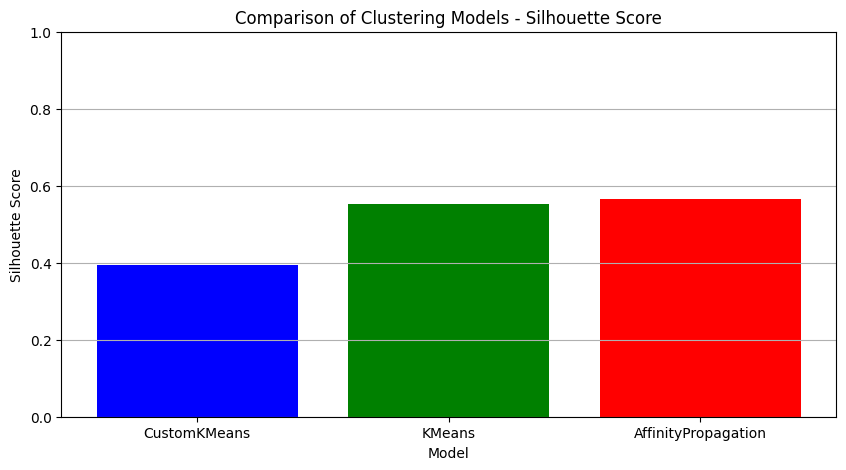

In [18]:
results = pd.DataFrame({
    'Model': ['CustomKMeans', 'KMeans', 'AffinityPropagation'],
    'Silhouette Score': [best_score_Customkmeans, best_score_kmeans, best_score],
})

plt.figure(figsize=(10, 5))
plt.bar(results['Model'], results['Silhouette Score'], color=['blue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('Silhouette Score')
plt.title('Comparison of Clustering Models - Silhouette Score')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


In [22]:
results_list = []
for n_components in [10, 20, 30, 40]:
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    # Обучение Custom KMeans
    best_score_Customkmeans, labels_Customkmean, time_Customkmeans = cluster_tuning_with_timing(
        X_pca, CustomKMeans, {'n_clusters': [4], 'max_iter': [best_params_Customkmeans['max_iter']]}
    )

    # Обучение KMeans
    best_score_kmeans, labels_kmean, time_kmeans = cluster_tuning_with_timing(
        X_pca, KMeans, {'n_clusters': [4], 'init': [best_params_kmeans['init']], 'n_init': [best_params_kmeans['n_init']]}
    )

    # Обучение AffinityPropagation (на подвыборке)
    X_sampled = shuffle(X_pca, random_state=42)[:5000]
    best_score_affinity, labels_affinity, time_affinity = cluster_tuning_with_timing(
        X_sampled, AffinityPropagation, {'damping': [best_params['damping']], 'preference': [best_params['preference']], 'max_iter': [1000]}
    )

    results_list.append({
        'PCA Components': n_components,
        'CustomKMeans Silhouette': best_score_Customkmeans,
        'KMeans Silhouette': best_score_kmeans,
        'AffinityPropagation Silhouette': best_score_affinity,
        'CustomKMeans Time (s)': time_Customkmeans,
        'KMeans Time (s)': time_kmeans,
        'AffinityPropagation Time (s)': time_affinity
    })
results_df = pd.DataFrame(results_list)


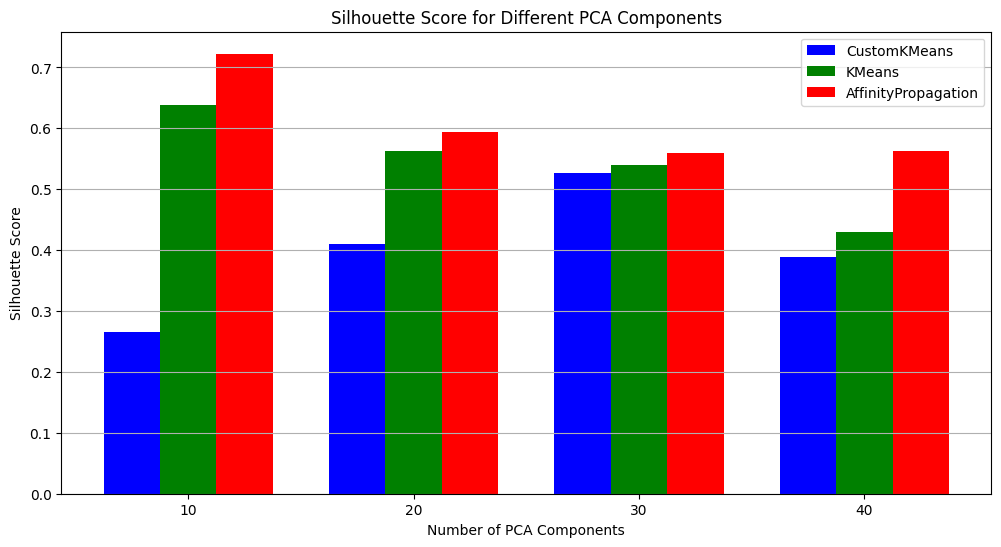

In [28]:
plt.figure(figsize=(12, 6))
bar_width = 0.25
x = np.arange(len(results_df['PCA Components']))

plt.bar(x - bar_width, results_df['CustomKMeans Silhouette'], width=bar_width, label='CustomKMeans', color='blue')
plt.bar(x, results_df['KMeans Silhouette'], width=bar_width, label='KMeans', color='green')
plt.bar(x + bar_width, results_df['AffinityPropagation Silhouette'], width=bar_width, label='AffinityPropagation', color='red')

plt.xlabel('Number of PCA Components')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different PCA Components')
plt.xticks(ticks=x, labels=results_df['PCA Components'])
plt.legend()
plt.grid(axis='y')

plt.show()

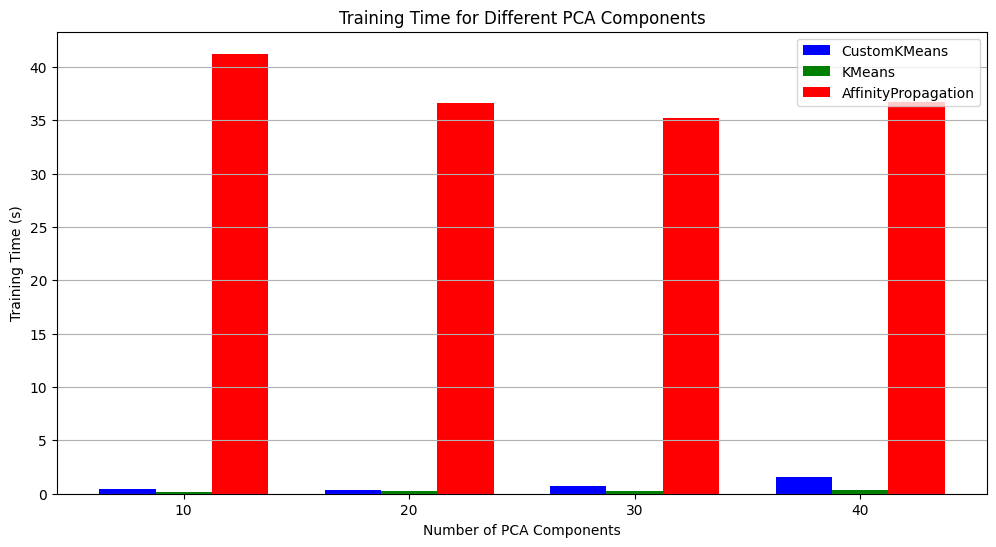

In [29]:
plt.figure(figsize=(12, 6))
bar_width = 0.25
x = np.arange(len(results_df['PCA Components']))

plt.bar(x - bar_width, results_df['CustomKMeans Time (s)'], width=bar_width, label='CustomKMeans', color='blue')
plt.bar(x, results_df['KMeans Time (s)'], width=bar_width, label='KMeans', color='green')
plt.bar(x + bar_width, results_df['AffinityPropagation Time (s)'], width=bar_width, label='AffinityPropagation', color='red')

plt.xlabel('Number of PCA Components')
plt.ylabel('Training Time (s)')
plt.title('Training Time for Different PCA Components')
plt.xticks(ticks=x, labels=results_df['PCA Components'])
plt.legend()
plt.grid(axis='y')

plt.show()

Итог:
- **AffinityPropagation** даёт лучшую кластеризацию по силуэтному коэффициенту, но требует значительно больше времени на обучение.
- **KMeans** — разумный компромисс между качеством и скоростью.
- **CustomKMeans** начинает с более низкого качества, но улучшает результаты при увеличении числа компонент.
